# Text Binary Classification based on BERT

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 5.2 MB/s 
     |████████████████████████████████| 596 kB 53.4 MB/s 
     |████████████████████████████████| 101 kB 10.9 MB/s 
     |████████████████████████████████| 6.6 MB 34.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import transformers
from transformers import AutoModel, AutoTokenizer, BertModel, AutoConfig, AdamW, get_linear_schedule_with_warmup

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import re
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

%matplotlib inline
%config InlineBackend.figure_format='retina' 

In [ ]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
torch.cuda.is_available()

False

## Load Dataset

Stanford Sentiment Treebank - Stanford Dataset for predicting Sentiment from longer Movie Reviews. The training set has 67349 rows. The test set has 872 rows.

We only use a subset of dataset due to limitation of computational resources.


In [ ]:
# Stanford Sentiment Treebank
train = pd.read_csv('./drive/MyDrive/Colab Notebooks/huggingface/datasets/sentiment-data/train.tsv', delimiter = '\t')
train = train.sample(12000)
test = pd.read_csv('./drive/MyDrive/Colab Notebooks/huggingface/datasets/sentiment-data/dev.tsv', delimiter = '\t')
# test = test.sample(48)
print("train.shape,test.shape",train.shape,test.shape)

train.shape,test.shape (12000, 2) (872, 2)


In [ ]:
train.head(3)

,sentence,label
66730,with outtakes in which most of the characters ...,0
29890,enigma is well-made,1
45801,is ) so stoked to make an important film about...,0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 66730 to 32957
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  12000 non-null  object
 1   label     12000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 281.2+ KB


In [ ]:
# no missing value
train[train['sentence'].isna()]

,sentence,label


In [ ]:
# roughly banlanced labels
train['label'].value_counts()

1    6756
0    5244
Name: label, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'label count')

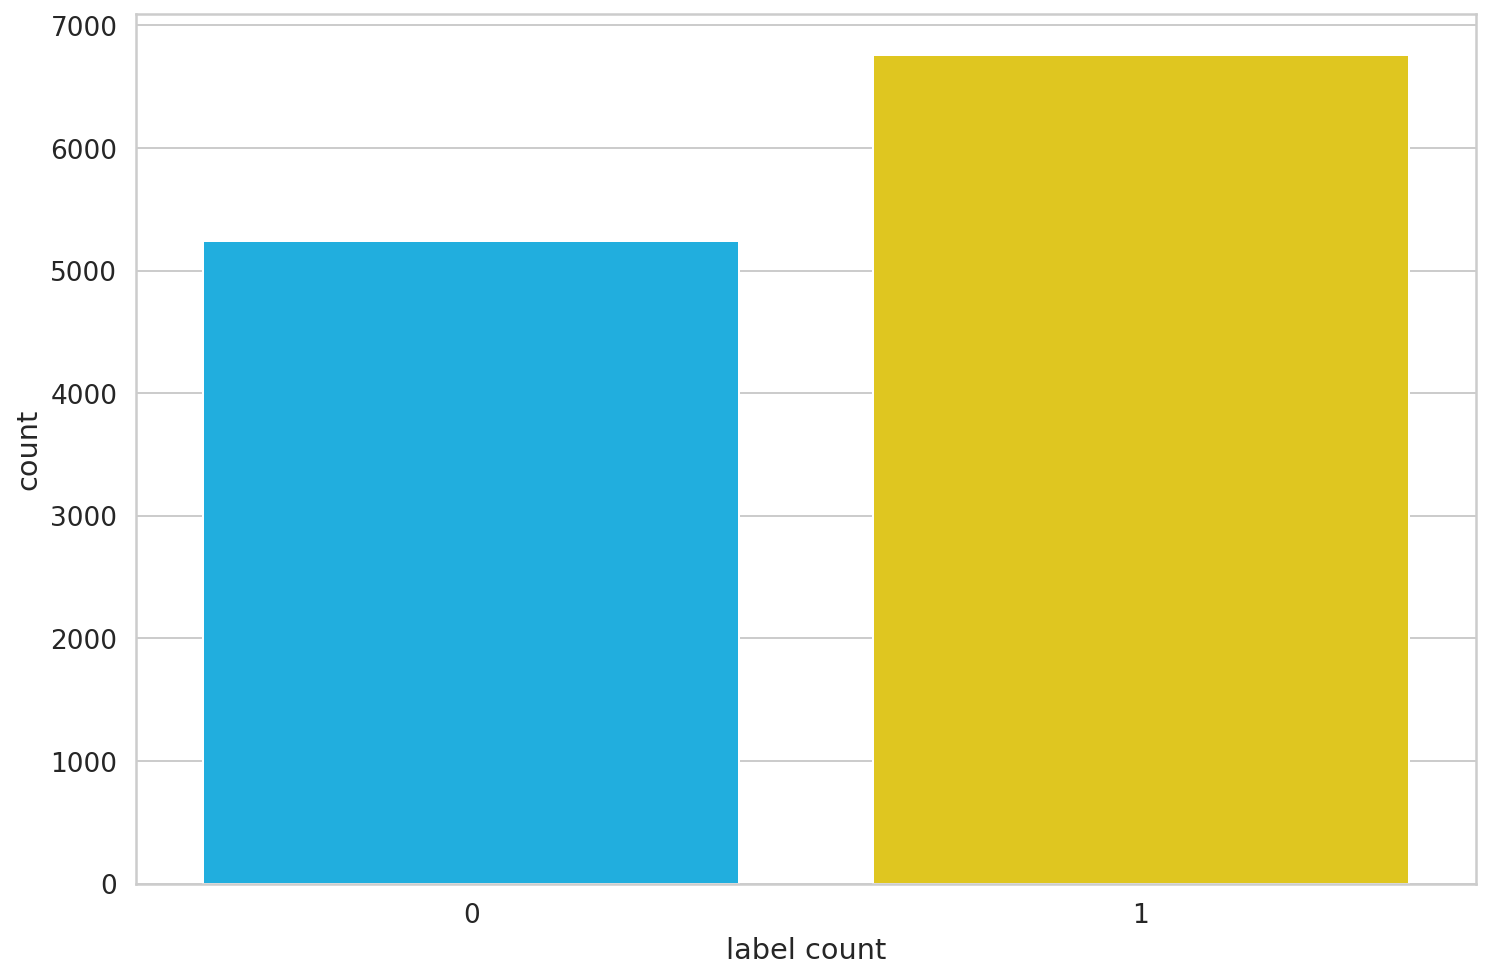

In [ ]:
sns.countplot(train.label)
plt.xlabel('label count')

In [ ]:
# number of characters in a sentence
train['sentence'].map(len)

66730    145
29890     20
45801    163
29352     52
19858     18
        ... 
60327     26
52950     34
63558     18
11941     41
32957     57
Name: sentence, Length: 12000, dtype: int64

In [ ]:
train['sentence'].map(len).describe()

count    12000.000000
mean        53.761500
std         43.217947
min          2.000000
25%         21.000000
50%         39.000000
75%         75.000000
max        261.000000
Name: sentence, dtype: float64

In [ ]:
test['sentence'].map(len).describe()

count    872.000000
mean     105.841743
std       48.133928
min        6.000000
25%       68.000000
50%      103.000000
75%      139.000000
max      244.000000
Name: sentence, dtype: float64

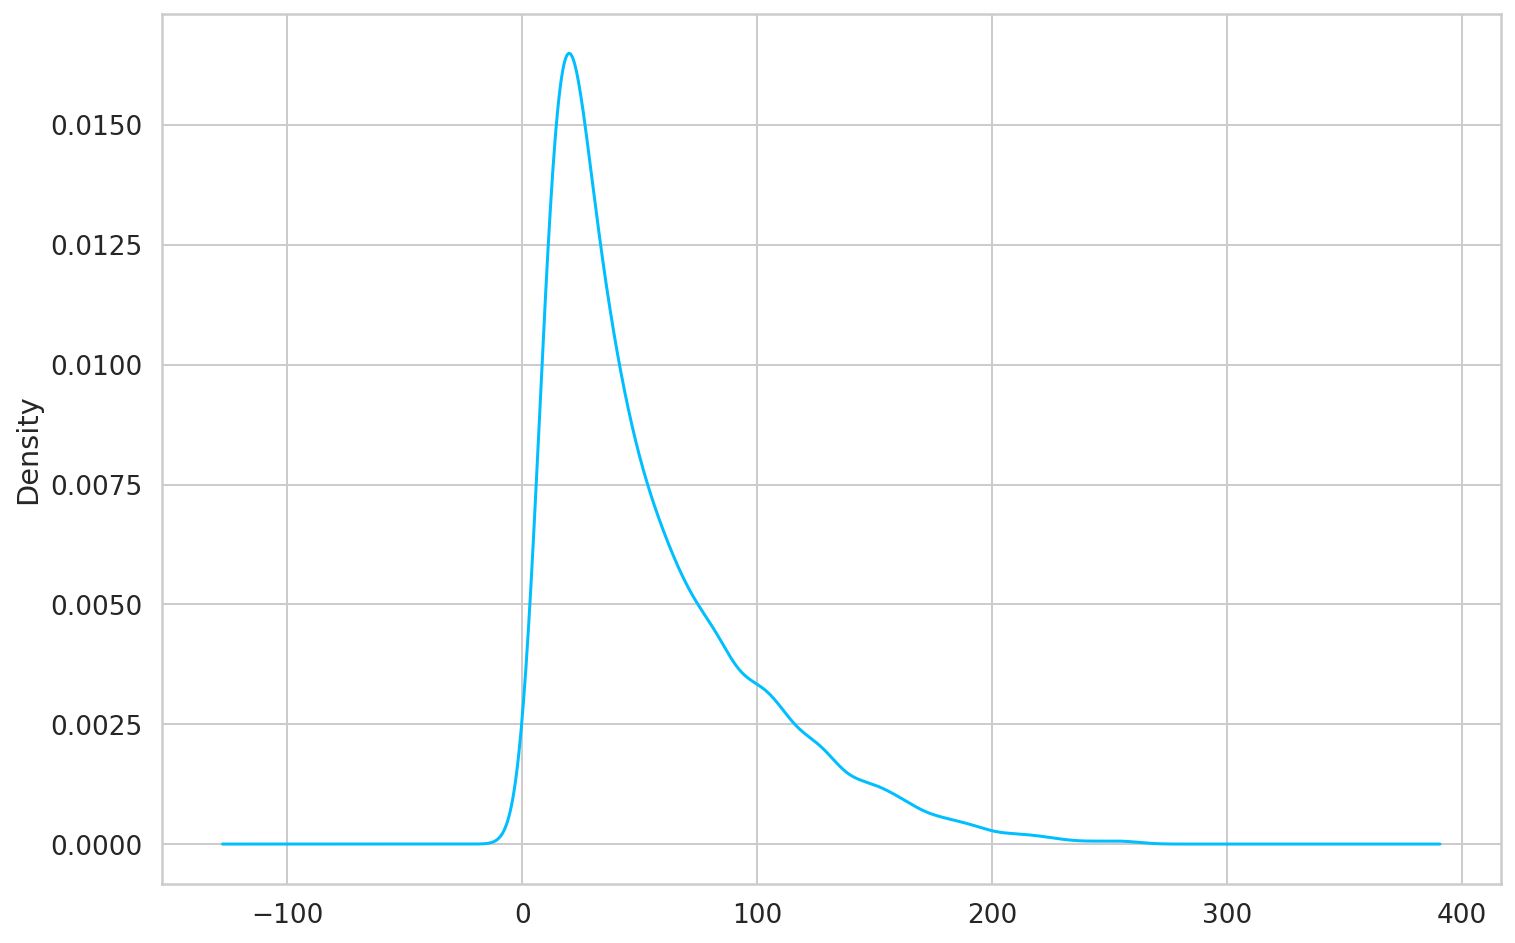

In [ ]:
text_len_tr=train['sentence'].map(len)
text_len_tr.plot(kind='kde')

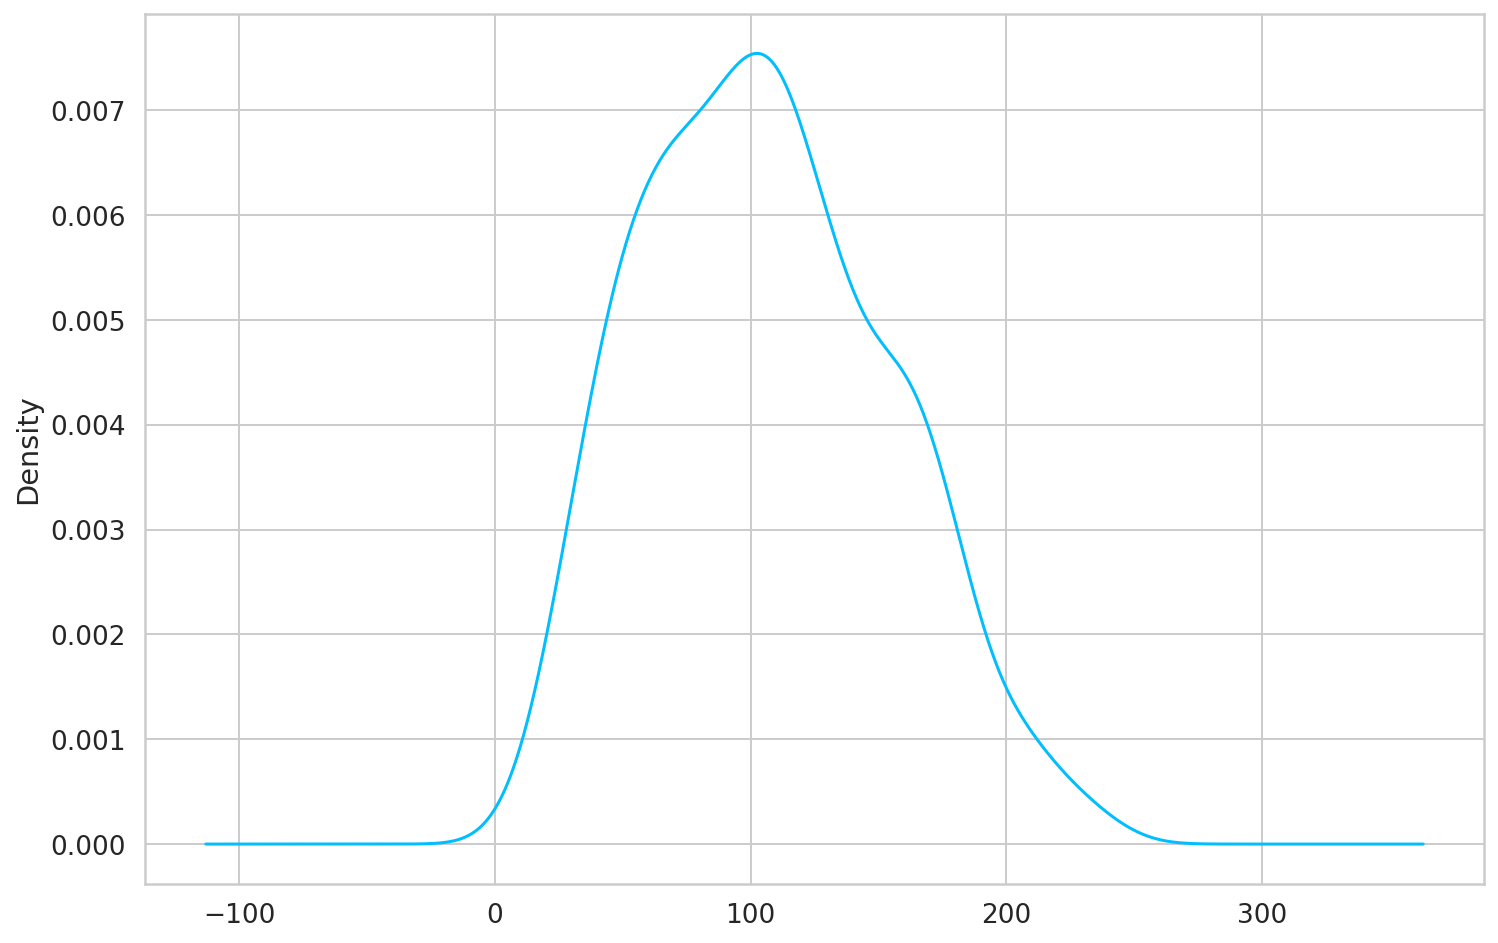

In [ ]:
text_len_ts=test['sentence'].map(len)
text_len_ts.plot(kind='kde')

In [ ]:
# sentence longer than 300
sum(text_len_tr>300) 
sum(text_len_ts>300) 

0

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

def token_len(sen):
  tokens = tokenizer.encode(sen, max_length = 300)
  return len(tokens)

train['token_len'] = train['sentence'].map(token_len)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


(11785, 4)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'label count')

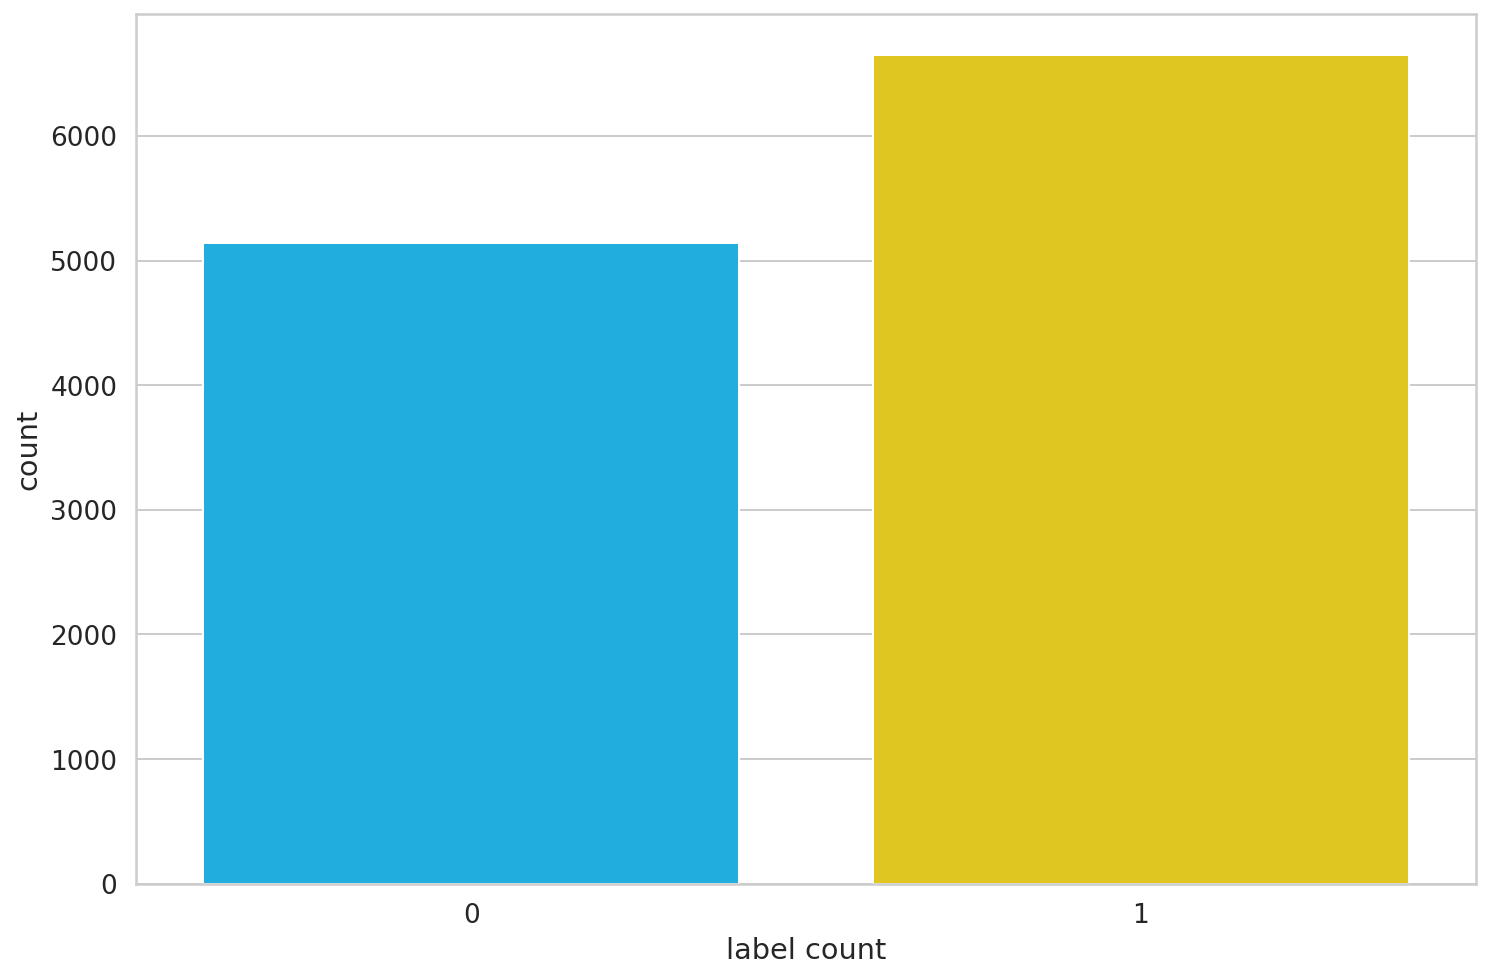

In [ ]:
train_select = train.iloc[np.where(train['token_len'] <= 40)].reset_index()
print(train_select.shape)

sns.countplot(train_select.label)
plt.xlabel('label count')

## Tokenization

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)


In [ ]:
# sample_txt = 'i love you'
# len(sample_txt)

# tokens = tokenizer.tokenize(sample_txt)
# token_ids = tokenizer.convert_tokens_to_ids(tokens)

# print(f'Text: {sample_txt}')
# print(f'Tokens: {tokens}')
# print(f'Token ids: {token_ids}')

In [ ]:
# # special tokens
# print(tokenizer.sep_token, tokenizer.sep_token_id)
# print(tokenizer.unk_token, tokenizer.unk_token_id)
# print(tokenizer.pad_token, tokenizer.pad_token_id)
# print(tokenizer.cls_token, tokenizer.cls_token_id)
# print(tokenizer.mask_token, tokenizer.mask_token_id)


In [ ]:
# encoding=tokenizer.encode_plus(
#     sample_txt,
#     # sample_txt_another,
#     max_length=32,
#     add_special_tokens=True,# [CLS]和[SEP]
#     return_token_type_ids=True,
#     padding='max_length',
#     return_attention_mask=True,
#     return_tensors='pt',# Pytorch tensor
# )

# print(len(encoding['input_ids'][0]))
# print(encoding)

# print(len(encoding['attention_mask'][0]))
# print(encoding['attention_mask'])
# encoding.keys()

In [ ]:
# tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

In [ ]:
token_lens = []

for txt in train_select.sentence:
    tokens = tokenizer.encode(txt, max_length=300)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


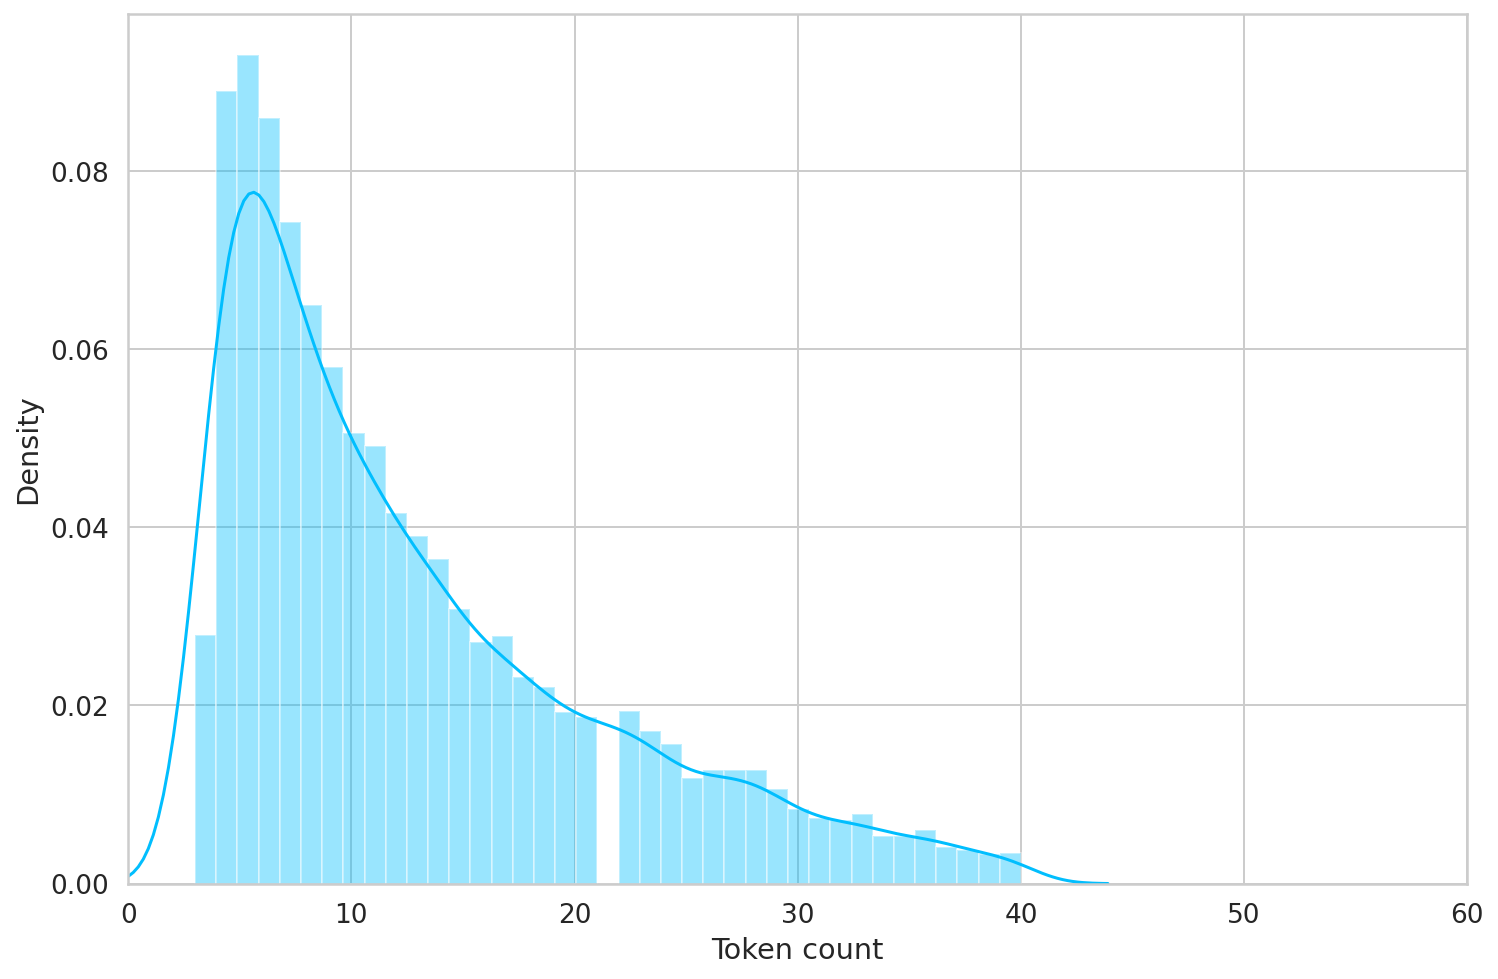

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 60]);
plt.xlabel('Token count');

In [ ]:
# max number of tokens in a sentence
max(token_lens)

40

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


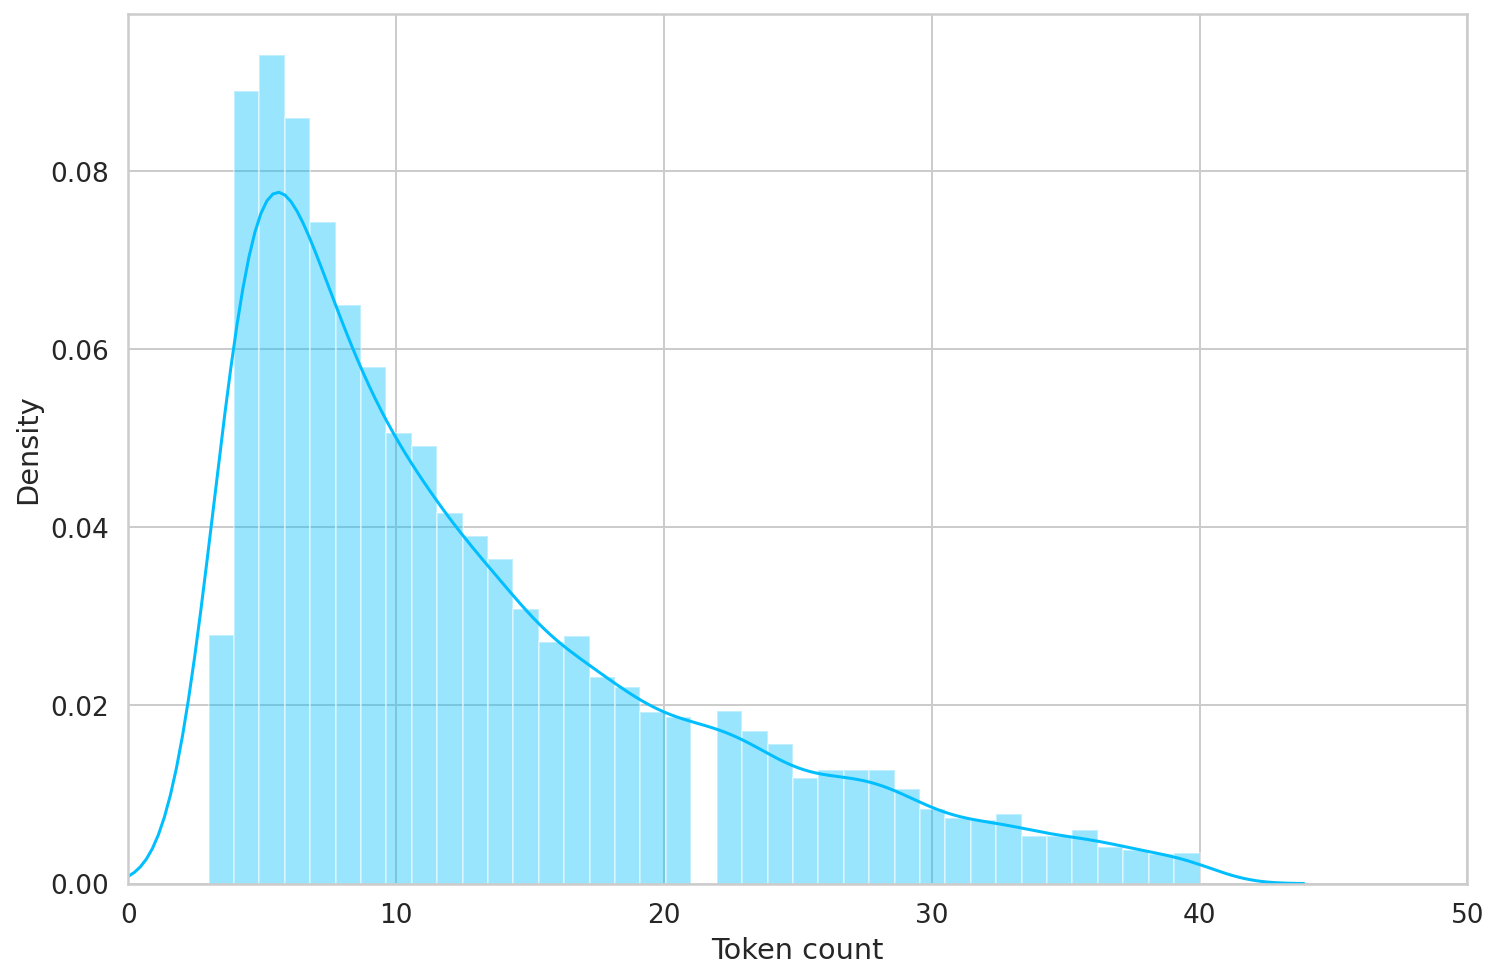

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 50]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = 40

## Construct Dataset

In [ ]:
class SSTDataset(Dataset):
    def __init__(self,texts,labels,tokenizer,max_len):
        self.texts=texts
        self.labels=labels
        self.tokenizer=tokenizer
        self.max_len=max_len
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self,item):
        text=str(self.texts[item])
        label=self.labels[item]
        
        encoding=self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        
#         print(encoding['input_ids'])
        return {
            'texts':text,
            'input_ids':encoding['input_ids'].flatten(),
            'attention_mask':encoding['attention_mask'].flatten(),
            # toeken_type_ids:0
            'labels':torch.tensor(label,dtype=torch.long)
        }

In [ ]:
# split dataset to train, val, test
df_train, df_test = train_test_split(train_select, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)
df_train.shape, df_val.shape, df_test.shape

((9428, 4), (1178, 4), (1179, 4))

In [ ]:
def create_data_loader(df,tokenizer,max_len,batch_size):
    ds=SSTDataset(
        texts=df['sentence'].values,
        labels=df['label'].values,
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
#         num_workers=4 # windows multi threads
    )

In [ ]:
BATCH_SIZE = 256

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
len(train_data_loader)

37

In [ ]:
# have a look at the data loader
next(iter(train_data_loader))

{'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'input_ids': tensor([[  101,  2108,  1037,  ...,     0,     0,     0],
         [  101, 22387,  2125,  ...,     0,     0,     0],
         [  101,  2024,  4394,  ...,     0,     0,     0],
         ...,
         [  101,  1996,  5694,  ...,     0,     0,     0],
         [  101,  5469,  1013,  ...,     0,     0,     0],
         [  101,  1006,  2009,  ...,     0,     0,     0]]),
 'labels': tensor([1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1,
         1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1,
         1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1,
         1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,
         1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['texts', 'input_ids', 'attention_mask', 'labels'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['labels'].shape)

torch.Size([256, 40])
torch.Size([256, 40])
torch.Size([256])


## Build Model

In [ ]:
bert_model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
bert_model

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [ ]:
# last_hidden_state, pooled_output = bert_model(
#     input_ids=encoding['input_ids'], 
#     attention_mask=encoding['attention_mask'],
#     return_dict = False
# )

# last_hidden_state # vectors of tokens
# pooled_output
# print(last_hidden_state.shape)
# print(pooled_output.shape)
# print(bert_model.config.hidden_size)
# print(pooled_output.shape)

In [ ]:
class SSTClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SSTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes) # two classes
        
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict = False
        )
        output = self.drop(pooled_output) # dropout
        return self.out(output)

In [ ]:
# change the number of output neuron
class_names=[0,1]

In [ ]:
model = SSTClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
data

{'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'input_ids': tensor([[  101,  2108,  1037,  ...,     0,     0,     0],
         [  101, 22387,  2125,  ...,     0,     0,     0],
         [  101,  2024,  4394,  ...,     0,     0,     0],
         ...,
         [  101,  1996,  5694,  ...,     0,     0,     0],
         [  101,  5469,  1013,  ...,     0,     0,     0],
         [  101,  1006,  2009,  ...,     0,     0,     0]]),
 'labels': tensor([1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1,
         1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1,
         1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1,
         1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,
         1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

# model(input_ids, attention_mask)
# F.softmax(model(input_ids, attention_mask), dim=1)

torch.Size([256, 40])
torch.Size([256, 40])


## Fine Tune the BERT Model

In [ ]:
EPOCHS = 3

optimizer = AdamW(model.parameters(), lr=1e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train() 
    losses = []
    correct_predictions = 0
    print('start')
    
    for ind_, d in enumerate(data_loader):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["labels"].to(device)
        
        print(f'run model: {ind_}')
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        _, preds = torch.max(outputs, dim=1)
        
        loss = loss_fn(outputs, targets)
        
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        loss.backward()
        
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval() 

    losses = []
    correct_predictions = 0
    print('start')
    with torch.no_grad():
        for ind_, d in enumerate(data_loader):
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["labels"].to(device)

            print(f'run model: {ind_}')
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
# torch.save(model.state_dict(), './drive/MyDrive/Colab Notebooks/huggingface/best_model_state.bin')

In [ ]:
history = defaultdict(list) 
best_accuracy = 0

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )

    print(f'Val loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), './drive/MyDrive/Colab Notebooks/huggingface/best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/3
----------
start
run model: 0
run model: 1
run model: 2
run model: 3
run model: 4
run model: 5
run model: 6
run model: 7
run model: 8
run model: 9
run model: 10
run model: 11
run model: 12
run model: 13
run model: 14
run model: 15
run model: 16
run model: 17
run model: 18
run model: 19
run model: 20
run model: 21
run model: 22
run model: 23
run model: 24
run model: 25
run model: 26
run model: 27
run model: 28
run model: 29
run model: 30
run model: 31
run model: 32
run model: 33
run model: 34
run model: 35
run model: 36
Train loss 0.41595339654265223 accuracy 0.7976240984302079
start
run model: 0
run model: 1
run model: 2
run model: 3
run model: 4
Val loss 0.24612324237823485 accuracy 0.9032258064516129

Epoch 2/3
----------
start
run model: 0
run model: 1
run model: 2
run model: 3
run model: 4
run model: 5
run model: 6
run model: 7
run model: 8
run model: 9
run model: 10
run model: 11
run model: 12
run model: 13
run model: 14
run model: 15
run model: 16
run model: 17
run mode

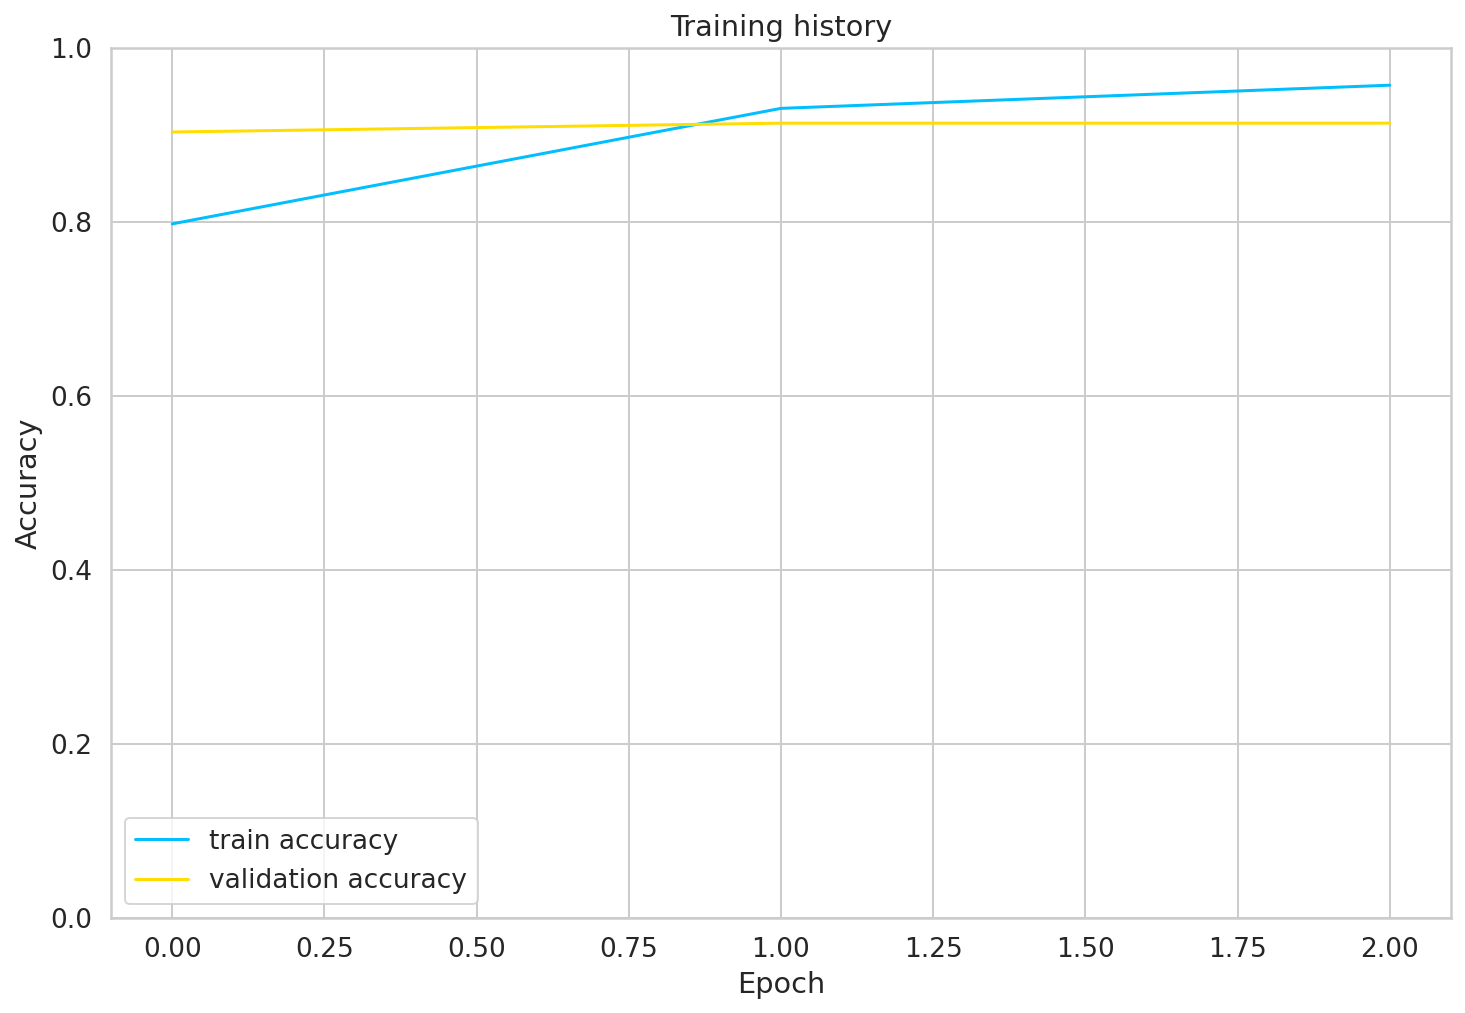

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

## Evaluation and Prediction

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

start
run model: 0
run model: 1
run model: 2
run model: 3
run model: 4


0.9168787107718406

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()

    raw_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["texts"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1) 

            probs = F.softmax(outputs, dim=1) 

            raw_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return raw_texts, predictions, prediction_probs, real_values

In [ ]:
y_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=[str(label) for label in class_names])) 

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       529
           1       0.94      0.90      0.92       650

    accuracy                           0.92      1179
   macro avg       0.92      0.92      0.92      1179
weighted avg       0.92      0.92      0.92      1179



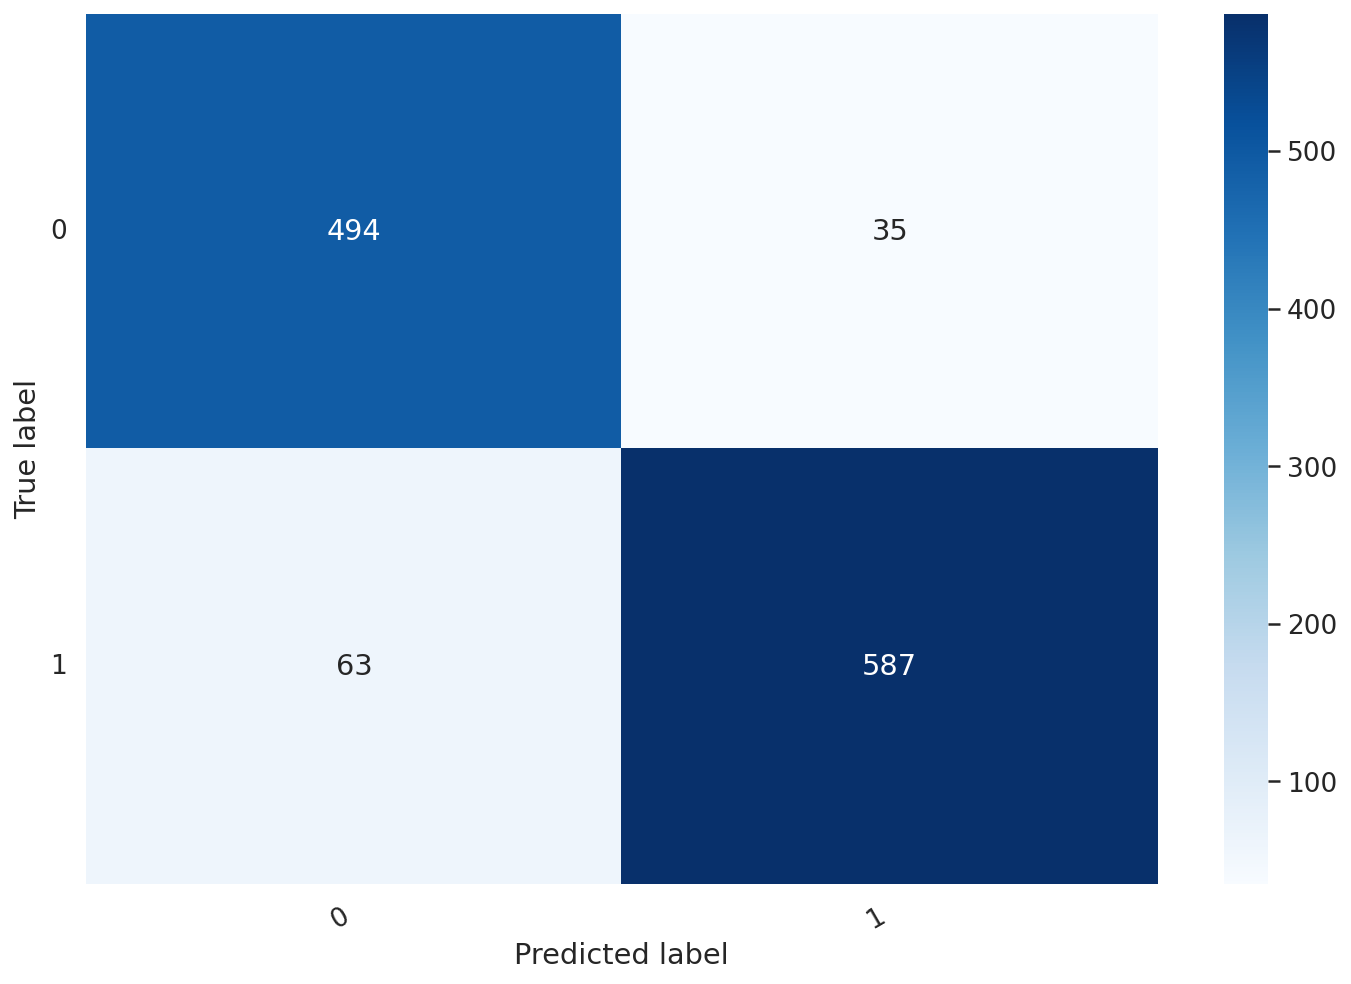

In [ ]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True label')
    plt.xlabel('Predicted label');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)